Whenever we're faced with a problem of any kind, the first thing we need to do is evaluate what we know about the problem and then choose a strategy for solving it. For example, if someone asks you how much the average world temperature will rise in the next ten years, you'd probably first take a long look at past temperatures, atmosphere compositions, industrial growth and any number of other factors that might be relevant. Once you looked at all this data, you have to decide how to use it. Do you think the temperature is going to be a linear function of the past temperatures, or is it some sort of complicated trigonometric polynomial involving the derivative of the atmospheric $\text{CO}_2$ levels? This decision is called <i>model selection</i> Once you've finished selecting a model, the final step is to fit the model - that is find a particular linear function or trigonometric polynomial that predicts the data well. This step is often called <i>optimization</i>

Obviously the model selection problem can be cast as an optimization problem - each "model" can be thought of as a family of prediction algorithms, and we'd like to choose the prediction algorithm that achieves the best performance out of the union of all of the models were considering.

More formally, let $X$ be the set of observations we can make to predict the temperature. So an element of $X$ would be some historical data about past temperatures and gas levels and so on. Let $Y=\R$ be the set of possible temperatures we could predict. Then suppose $D$ is a probability distribution over $X\times Y$. $D$ represents the "real world" relationship between past history and temperature. We're interested in finding a function $f:X\to Y$ such that for $(x,y)\sim D$, $f(x)$ is a good approximation or prediction of $y$. In order to evaluate how "good" an approximation or prediction is we have a cost function $C$, where

$$
C(f) = \E_{(x,y)\sim D}c(f,x,y)
$$

We're looking for a function $f$ that minimizes $C$. 
For example, $c(f,x,y)$ could be $(f(x)-y)^2$. In this case, minimizing $C$ corresponds exactly to finding the <i>least squares</i> regression solution for predicting $y$ given $x$.

Instead of considering all possible functions $X\to Y$, we'll consider only a subset of functions $H$. We do this for two reasons. First of all, normally we only have access to a dataset of pairs $(x,y)$ drawn from $D$ rather than the whole distribution. Thus we can't actually evaluate $C$ - we have to make due with some approximation using our dataset. Because of this we have to worry about the problem of <i>overfitting</i> - a function that does really well on our dataset might not be optimal for the real world. A way to fix this is to use a restricted subset of functions $H$. The ability to choose sets $H$ that will avoid overfitting is in of itself a really interesting field, but we'll jump over it here. A second reason to restrict to a subset $H$ is that we may not have a good algorithm for searching over the set of all functions to find a minimizing function, while it may be feasible to search over some subset.

In any event, we'll call this subset $H$ a model. Thus the task of model selection is the task of choosing a subset $H$ while the task of optimization is choosing an $f$ in $H$ that minimizes $C$.

Now let's consider an online learning problem. In this case, we are presented with an input $x_t$, we make a prediction $f_t(x_t)$, and then learn the true value $y_t$. Then we use this information to decide upon an $f_{t+1}\in H$ and the process repeats for $T$ rounds.

We're interested in minimizing our total loss:

$$
\sum_{t=1}^T c(f_t,x_t,y_t)
$$

We're going to try to perform "online model selection". For this we'll redefine what we mean by a "model". Instead of just a set $H$, a model is a set $H$ along with an online learning algorithm $A_H$. With some abuse of notation, we'll use $H$ to stand in for the pair $(H,A_H)$. Let $L(H,t)$ be the total loss suffered by model $H$ after $t$ rounds. Suppose we know $L(H,t)$ for several different models. Then if we are going to play the online learning game for $T$ rounds, obviously we'd like to use the model $H$ that minimizes $L(H,T)$. Unfortunately we almost certainly do not know $L(H,t)$ for any $H$. So what can we do?

For simplicity, suppose that we are only considering two possible models, $H_1$ and $H_2$. The extensions to arbitrarily many models will be fairly straightforward.

<h4>Prediction with Expert Advice</h4>

There is a common type of problem known as prediction with expert advice. In this problem, one has a set of "experts" $h_1,\dots,h_n$ which are all functions $X\to Y$. Upon receiving example $x$, one evaluates $h_1(x),\dots,h_n(x)$ and uses these values to choose a prediction $\hat y$. The goal is to do as well as if you had picked the "best overall" expert and just used its predictions on every round. There are algorithms to do this well. In fact, it's possible to do this even if you only get to evaluate <i>one</i> expert on each round (this is known as the "multi-armed bandit" problem). 

We can easily apply these algorithms to our problem: at each round, use the given $x$ and $y$ values to update both $H_1$ and $H_2$ and use a prediction with expert advice algorithm to choose an output based upon the predictions and performances of $H_1$ and $H_2$. This is guaranteed to work nearly as well as just choosing the better one of $H_1$ and $H_2$ from the beginning. So problem solved!

<h4>Restricting Computation</h4>

Let's make life a little harder. Notice that in the prediction with expert advice scheme, if we are comparing $K$ models for $T$ rounds, we neeed to use $O(KT)$ resources to update all the models. This may not be desireable - ideally the number of resources would not grow so fast with $K$. So let's try to do something different.

One might think that a bandit algorithm will save the day here, since they don't require us to evaluate each model at each time step. Unfortunately, this is not going to work because now each "expert" gets better every time we use it. The bandit algorithm can easily get stuck in a situation where it spends all its time exploiting a model that is better for a short period of time but is much worse in the long term because the better model never gets enough time to demonstrate its superiority.

Instead, let's go back to the situation in which we know $L(H,T)$. We don't actually know these values, but after playing $H$ for $T'$ rounds, we <i>do</i> know $L(H,t)$ for all $t\le T'$. We'll use this to estimate $L(H,T)$. For this task we're going to have to use model selection and optimization, which is itself an interesting thought - perhaps it's possible to recurse on this procedure. In any event, we'll assume that $\frac{1}{t}L(H,t)$ follows a power law: $\frac{1}{t}L(H,t) = Kt^{\alpha}+R$. This is our model. Of course this is not going to be strictly true, but almost all online learning algorithms come with theoretical guarantees that $\frac{1}{t}L(H,t)$ will be bounded by such a law. In practice the upper bounds tend to be loose, but the actual $L$ curves do indeed follow power laws like this (at least in a piece-wise manner) although possibly with different constants.

This suggests a simple algorithm. Power laws are linear in log-space, and so we can use linear regression to maintain an estimate of the $L(H,T)$ for $H_1$ and $H_2$ (this is the optimization step). With a little algebraic manipulation, one can see that the update to the linear regression can be performed in constant time. Thus our procedure is to pick the model that has the lowest estimate $\hat L(H,T)$. Unfortunately, this by itself is not good enough because our estimates are just that - estimates. We can't afford to ignore the possibility that we might be wrong, so we'll add in an "exploration" factor - on every round with some small probability we'll just pick a random model.

There is one final subtlety to deal with. Suppose we've run model $H_1$ for $10$ steps, model $H_2$ for 5 steps, and $T=20$. Then when deciding which model to use next, instead of comparing $L(H_1,20)$ to $L(H_2,20)$, we should take into account the fact that there are only $5$ additional rounds of updates. Thus we really need to compare $ L(H_1,20)- L(H_1,15)$ to $L(H_2,10)- L(H_2,5)$. That is, we compare the total <i>additional</i> loss we'll suffer from using one model vs another. It might be that we've wasted so much time on a particular model that even though it's not the best overall we'll still be better off sticking with it instead of switching over to the a-posteriori better model.

The full algorithm is:

<div class="algorithm">
<ol>
<li>Initialize $t_1=t_2=0$.</li>
<li>Initalize power-law fit parameters for $H_1$ and $H_2$</li>

For $t=1,\dots,T$ :

<li> Receive input $x_t$.</li>
<li> Let $z = \argmin_i \hat L(H_i,T-t_i)-\hat L(H_i,t_i)$.</li>
<li> With probability $1-\epsilon_t$, let $z = \argmin_z \hat L(H_i,T-t_i)-\hat L(H_i,t_i)$.</li>
<li> Otherwise, let $z$ be $1$ or $2$ uniformly at random.</li>
<li> Send $x_t$ to $H_z$ and output prediction $\hat y_t$
<li> Receive the true value $y$ and update $H_z$.</li>
<li> Set $t_z = t_z+1$.</li>
<li> Update power-law parameters for $L(H_z,t)$.</li>
</ol>

</div>

I think a reasonable value to use for $\epsilon_t$ is $\frac{1}{\sqrt{t}}$. This has the advantage of allowing each model to be queried a large number of times ($\sum_{t=1}^\infty \frac{1}{\sqrt{t}}$ diverges), but also allows us to use our best-estimate almost all the time. Another reason to choose $\frac{1}{\sqrt{t}}$ is that many online learning algorithms have a regret bound of $O(\sqrt{T})$, and this choice of exploration rate meshes nicely with the $\sqrt{T}$ convergence rate.

In practice, we probably want to run each model for some small fixed number of "burn-in" iterations (say 100) to seed the power-law fits.

<h4>Unknown $T$</h4>

Suppose we don't actually know the time-horizon $T$. In this case we make use a simple "doubling trick". Just assume that $T$ is the smallest power of 2 that is greater than the current iteration number. This guarantees that our guess for $T$ will be off by at most a factor of 2 from the true value for at least half the time, which should result in some constant factor performance degradation.

Let's test this out! We'll use the <a href =http://yann.lecun.com/exdb/mnist/>MNIST</a> digit-recognition dataset to test things out. Our different models will be linear classification applied to the original data as well as <a href=http://machinelearning.wustl.edu/mlpapers/paper_files/NIPS2007_833.pdf>random Fourier features</a> for gaussian kernels with a couple of different distance parameters. It's not super important to know what Fourier features are here; all that matters is that given a distance parameter $\sigma$ and a dimensionality parameter $n$, Fourier features provide a model that we can optimize over. 

I'll use two copies of each model. The idea is that this makes life actually harder for our algorithm: it needs to avoid splitting its time equally among the copies and instead just concentrate on one of them.

In [45]:
# <!-- hide=True -->
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from sklearn.datasets import load_digits,load_boston,load_diabetes,load_iris
from sklearn.datasets import fetch_mldata
%matplotlib inline  

In [2]:
# <!-- hide=True -->
class FourierFeature:
    '''impements random fourier features for gaussian kernels: k(x,y)=exp(-(x-y)^2/sigma)
        member values:
        d: input dimensionality (dimensionality of x and y in k(x,y))
        n: feature dimensionality (output is a vector in R^n)
        w: angles to use in generating the feature.'''
    def __init__(self,d,n,sigma):
        self.w = np.random.normal(0,sigma,(n,d))
        self.n = n
        self.d = d
    
    def __call__(self,data):
        
        dotp = np.dot(self.w,data).flatten()
        return np.concatenate((np.sin(dotp),np.cos(dotp)))/np.sqrt(self.n)

In [3]:
# <!-- hide=True -->
def multiclasshinge(w,x,y):
    """computes multiclass hinge loss and its gradient
    
        
        w: input prediction matrix
        x: input example to predict class for
        y: target class"""
    pred = np.dot(w,x)
    
    #grab the largest prediction not equal to the correct class:
    ps = list(np.argsort(pred))
    if(ps[-1]!=y):
        trueloss = 1.0
    else:
        trueloss = 0.0
    ps.remove(y)
    p = ps[-1] 
    
    grad = np.zeros(np.shape(w))
    loss = max(0,1+pred[p]-pred[y])

    if(loss != 0):
        grad[p] = np.copy(x)
        grad[y] = np.copy(-x)
    return loss,grad

def hingeloss(w,t,data,featurizer = lambda x:x):
    l = len(data.target)
    #v = t%l
    v = np.random.random_integers(0,l-1)
    y = int(data.target[v])#*2-1
    x = np.append(featurizer(data.data[v].flatten()),1)
    return multiclasshinge(w,x,y)

In [46]:
# <!-- hide=True -->
class AdaStep:
    '''class for running adagrad on a model and maintaining \hat L estimate'''
    def __init__(self,winit,D,lossandgrad,name,adab = False):
        self.w = np.copy(winit)
        self.winit = np.copy(winit)
        self.L = 0.000001*np.ones(np.shape(winit))
        self.totloss = 0
        self.D =D
        self.lossandgrad = lossandgrad
        self.name = name
        self.adab = adab
        self.reset()

        
    def reset(self):
        self.losses = []
        self.w = np.copy(self.winit)
        self.L = 0.000001*np.ones(np.shape(self.winit))
        self.t = 0 
        self.totloss = 0
        self.R=0
        self.losses = []
        self.M = np.matrix(np.eye(2)*0.01)
        self.xy = np.zeros((2,1))
        self.m = np.zeros(2)
        self.step = np.ones(np.shape(self.w))*self.D
        if(self.adab):
            self.alpha = 1.0/np.sqrt(2)
        else:
            self.alpha = 0.679

    def __call__(self,T):
        l,g = self.lossandgrad(self.w,self.t)
        
        self.totloss += l
        
        self.losses.append(self.totloss/(self.t+1.0))

        if(self.adab):
            test = np.abs(self.w)>self.step*(1+self.alpha)
            self.L[test] = 0.00001
            self.step[test] *= (1+self.alpha)
        
        self.L += g**2
        self.w = self.w - self.alpha*self.step/(np.sqrt(self.L))*g
        
        if(not self.adab):
            self.w = np.clip(self.w,-self.D*0.5,0.5*self.D)
        self.t += 1
        
        #update m
        x = np.log(self.t)
        y = np.log(self.totloss/self.t+0.0001)
        self.M += self.t*np.matrix([[x**2,x],[x,1]])
        self.xy+= self.t*np.array([[x*y],[y]])
        self.m = self.M.getI()*self.xy
        
        
        
        return {"loss":l,"predict":self.predict(T)}
        
    def Lhat(self,T):
        return np.exp(np.dot(np.array([np.log(T+0.001),1]),self.m))[0,0]*T
    def predict(self,T):
        return self.Lhat(T+self.t)-self.Lhat(self.t)

In [47]:
# <!-- hide=True -->
def AlgSelect(algs,T,tmin,guessT = True):
    '''runs the model selection algorithm
    algs: list of models - should be instances of AdaStep, or support similar function calls
    T: number of time steps to run
    tmin: seed each model with tmin initial steps
    guessT: boolean. If true, then we use the doubling trick to deal with unknown T.'''
    
    loss = np.zeros(T)
    bounds = np.zeros((len(algs),T))
    counts = np.copy(bounds)
    totloss = 0
    choices = np.zeros(T)
    randoms = np.zeros(T)
    Ms = []
    for alg in algs:
        alg.reset()
    n = len(algs)
    
    #run every algorithm tmin steps to seed the risk estimates:
    for t in xrange(tmin):
        data = [alg(T) for alg in algs]
        totloss += reduce(lambda x,y:x+y,[d["loss"] for d in data])
        loss[n*t:n*t+n] = totloss/(n*t+n)
        bounds[n*t:n*t+n] = totloss/(n*t+n)
    
    count = 0
    M = tmin*2
    if(not guessT):
        M=T
    risks = np.array([alg.predict(M) for alg in algs])
    for t in xrange(T):
        Ms.append(M)
        if(t>=M):
            M *= 2
        chance = np.random.binomial(1.0,1.0/np.sqrt(t+1.0))
        best = np.argmin(risks)
        if(chance):
            count += 1
            randoms[t] = 1
            best = np.random.random_integers(0,len(algs)-1)
        choices[t]=best

        lp = algs[best](t)
        totloss += lp["loss"]
        risks = np.array([alg.predict(M-t) for alg in algs])
        bounds[:,t] = np.copy(np.array(risks))
        for i in xrange(len(algs)):
            counts[i,t]=algs[i].t
        loss[t]=totloss/(t+tmin*n)
    return {"loss":loss,"bounds":bounds,"choices":choices,"randoms":randoms,"counts":counts,"M":Ms}

In [71]:
# <!-- hide=True -->
def plotselect(select,algs,overlaypred=True):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,0)
    for alg in algs:
        ax.plot(alg.losses,label=alg.name)
        if(overlaypred):
            preds = [(alg.Lhat(t))/(t+1.0) for t in xrange(T)]
            ax.plot(preds)#,label=alg.name+" pred")
    ax.plot(select["loss"],label="Select")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Average Loss')
    ax.set_xlabel('Time')
    ax.legend()
    ax.set_title("losses")
    plt.show()
def plotbounds(select,loc=3):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,0)
    for t in xrange(len(select["bounds"])):
        ax.plot(select["bounds"][t],label = algs[t].name)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend(loc=loc)
    ax.set_title("Estimated model value over time: $\hat L(H,T) - L(H,t)$")
    ax.set_xlabel('Time')
    plt.show()
def plotcounts(select):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1,2,1)
    for t in xrange(len(select["counts"])):
        plt.plot(select["counts"][t],label = algs[t].name)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title("Model use over time")
    ax.set_xlabel('Time')
    plt.legend(loc=2)
    
    ax = fig.add_subplot(1,2,0)
    totalcount = reduce(lambda x,y: x+y,select["counts"])
    for t in xrange(len(select["counts"])):
        plt.plot(select["counts"][t]/totalcount,label = algs[t].name)
    ax.set_xscale('log')
    ax.set_title("Fraction of model use")
    ax.set_xlabel('Time')
    plt.legend(loc=2)
    
    plt.show()

In [49]:
# <!-- hide=True -->
classes = 10

mnist = fetch_mldata('MNIST original', data_home="datahome/")
mnist.data = mnist.data/255.0

Dlin = 1.0
Fn = 1000
Fn2 = 1000
Df = 1.0
sigma = 10
sigma2 = 5

In [50]:
# <!-- hide=True -->
imagelossgrad = lambda w,t:hingeloss(w,t,mnist)
imagewinit = np.zeros((classes,1+np.shape(mnist.data[0])[0]))

Ff = FourierFeature(np.shape(mnist.data[0])[0],Fn,sigma**(-1))
Fimagelossgrad = lambda w,t:hingeloss(w,t,mnist,featurizer = Ff)
Fimagewinit = np.zeros((classes,1+np.shape(Ff(mnist.data[0]))[0]))

Ff2 = FourierFeature(np.shape(mnist.data[0])[0],Fn2,sigma2**(-1))
Fimagelossgrad2 = lambda w,t:hingeloss(w,t,mnist,featurizer = Ff2)
Fimagewinit2 = np.zeros((classes,1+np.shape(Ff2(mnist.data[0]))[0]))

adalin = AdaStep(np.copy(imagewinit),Dlin,imagelossgrad,"Linear",adab=True)
adalincopy = AdaStep(np.copy(imagewinit),Dlin,imagelossgrad,"Linear copy",adab=True)
adaF = AdaStep(Fimagewinit,Df,Fimagelossgrad,"Fourier $\sigma=%.2f$, $n=%d$" %(sigma,Fn),adab=True)
adaFcopy = AdaStep(Fimagewinit,Df,Fimagelossgrad,"Fourier $\sigma=%.2f$, $n=%d$" %(sigma,Fn),adab=True)
adaF2 = AdaStep(Fimagewinit2,Df,Fimagelossgrad2,"Fourier $\sigma=%0.2f$, $n=%d$" %(sigma2,Fn2),adab=True)
adaF2copy = AdaStep(Fimagewinit2,Df,Fimagelossgrad2,"Fourier $\sigma=%0.2f$, $n=%d$" %(sigma2,Fn2),adab=True)

In [51]:
# <!-- hide=True -->
T = 10000
tmin = 100
guessT = False
algs = [adaF,adaFcopy,adaF2,adaF2copy,adalin,adalincopy]
select = AlgSelect(algs,T,tmin,guessT)

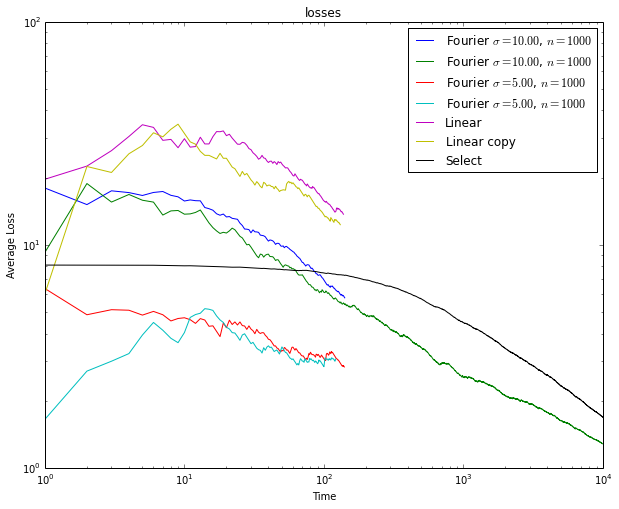

In [52]:
# <!-- hide=True -->
plotselect(select,algs,overlaypred = False)

Here we've plotted the our model selection algorithm's average loss over time ("Select") as well as the observed average losses of the various models. Many of the observed losses do not cover the entire time-span (technically none of them do). These limited ranges reflect the number of times the selection algorithm used each particular model. Notice that although the $\sigma=5$ Fourier classifier starts off doing better, the selection algorithm immediately realizes that the $\sigma=10$ Fourier features are better overall and uses them instead. It ignores the linear classifiers, and manages to commit to using a single one of the $\sigma=10$ Fourier feature classifiers.

An important thing to note here is that we needed to use a burn-in period of 100 iterations. That is, we run each model for 100 iterations in order to get a good initializion for the $L(H,t)$ estimators. If we use a smaller burn-in period we need many more iterations before the selection procedure realizes that the $\sigma=5$ Fourier features are not the best. Later we'll provide an algorithm that can do well with a very small burn-in period.

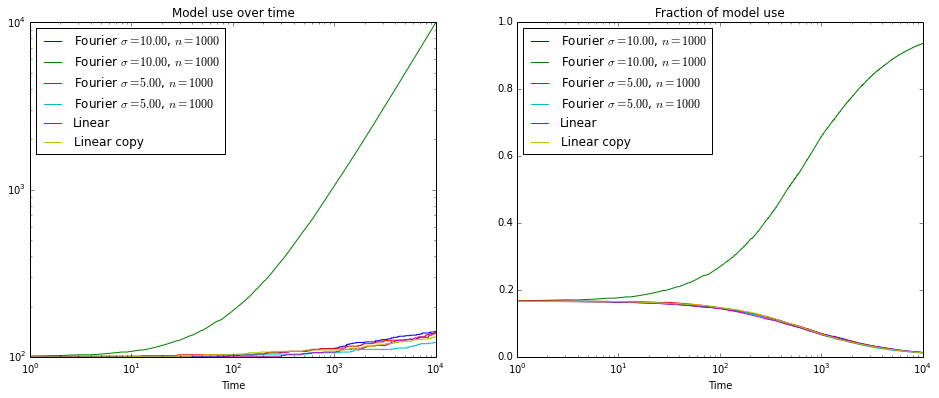

In [53]:
# <!-- hide=True -->
plotcounts(select)

This is a plot of the number of times each model was used over time, as well as the fraction of uses each model saw. As you can see, we essentially only use the $\sigma=10$ Fourier features. Everything else is used a small number of times following the exploration schedule.

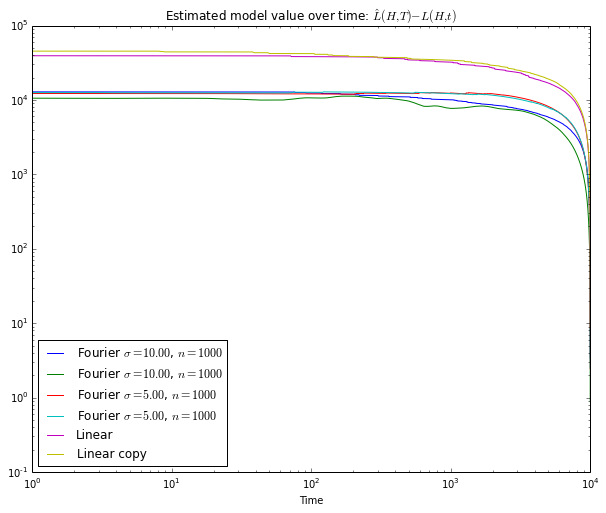

In [54]:
# <!-- hide=True -->
plotbounds(select)

Finally, here are the estimates of additional loss for each model over time.

So let's make life a little more difficult by having our algorithm use the doubling trick to guess how much time is remaining. In this case we'd expect to spend more time on either the $\sigma = 5$ Fourier features because for small $T$ values they are in fact superior, as one can see from the first plot.

In [55]:
# <!-- hide=True -->
T = 10000
tmin = 100
guessT = True
algs = [adaF,adaFcopy,adaF2,adaF2copy,adalin,adalincopy]
select = AlgSelect(algs,T,tmin,guessT)

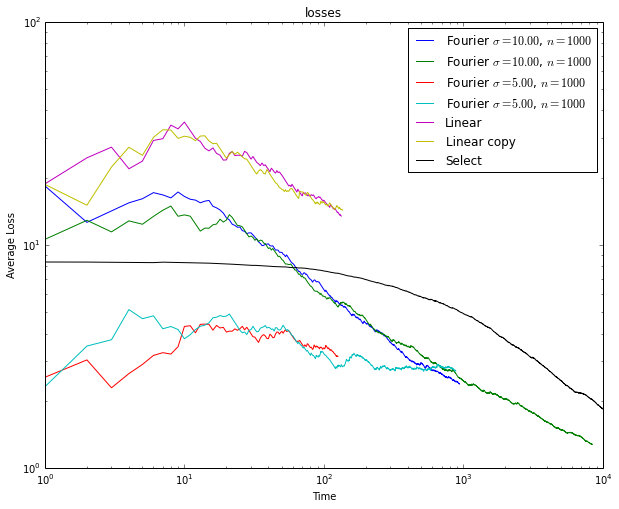

In [56]:
# <!-- hide=True -->
plotselect(select,algs,overlaypred = False)

So now we're spending a lot more time time on the $\sigma=5$ Fourier features. At around $1000$ iterations, we finally decide to start using the $\sigma=10$ Fourier features. This is illustrated in the model-use and estimated performance plots below.

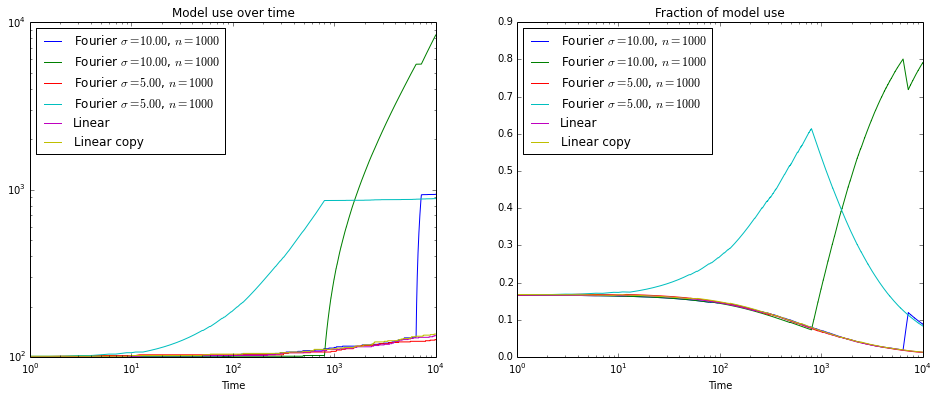

In [57]:
# <!-- hide=True -->
plotcounts(select)

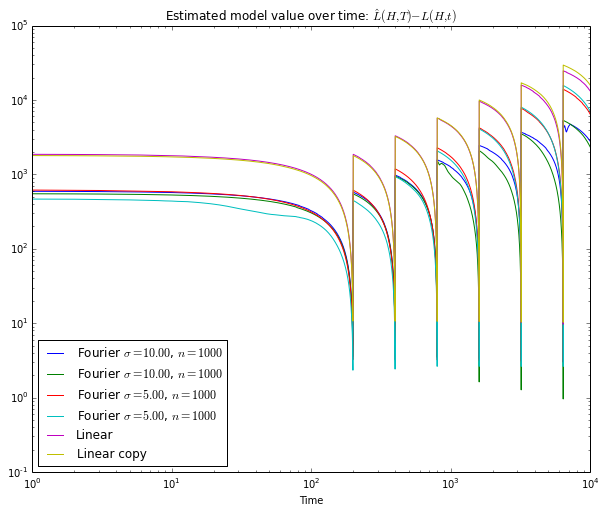

In [58]:
# <!-- hide=True -->
plotbounds(select)

Notice that now the estimated losses for the models are actually <i>increasing</i> over time rather than decreasing. This is because our guess for $T$ is increasing and so we're expecting to have to deal with more and more iterations in which to accumulate loss.

<h4>More Computation and Bandits</h4>

The amount of computational resources used in this model selection procedure is bounded by the resources required to run any one of the models, but it might be possible to do a little better by using a little more computer power. The idea is very simple - we'll do some kind of interpolation between the current set-up and the $O(KT)$ "prediction with expert advice" scenario.

To do this, we use a bandit algorithm to choose which algorithm to actually output with. We then update the selected algorithm, as well as two other algorithms. One of these should be the algorithm that we believe (via the estimated $L(H,T)$ scheme) to be the best, and the other is randomly selected. This multiplies our computation by a factor of three, but should result smoothing out the bumps, as well as faster convergence overall. In particular, the "best" expert in the view of the bandit scheme will necessarily be the model with the best average observed loss in the previous algorithm. Since the bandit algorithm is guaranteed to do nearly as well as this expert we can expect very good performance.

<div class = "algorithm">
<ol>
<li>Initialize $t_1,\dots,t_K=0$.</li>
<li>Initialize power-law fits for $H_1,\dots,H_K$.</li>
<li>Initialize $K$-armed bandit algorithm $A$.</li>
For $t=1,\dots,T$ :
<li> Recieve input $x_t$.</li>
<li> Use a bandit algorithm $A$ to choose a model $i$.</li>
<li> Output prediction from model $H_i$.</li>
<li> Receive $y_t$.</li>
<li> Update model $H_i$ (both the model optimization as well as power-law fits).</li>
<li> Let $z = \argmin_{z\ne i} \hat L(H_i,T-t_i)-\hat L(H_i,t_i)$.</li>
<li> Update model $H_z$.</li>
<li> Choose a model uniformly at random (other than $H_i$ and $H_z$) and update it as well.</li>
</ol>
</div>

This algorithm still only needs $O(T)$ resources, although the constant is three times worse than in the previous algorithm. However, we'll see that the convergence rates are better. Further, the previous algorithm needed a burn-in period of 100 iterations in order to converge on the correct model within 10000 iterations. While this is not an extremely large period, it would be better if we didn't need it; this bandit-based algorithm can perform well with a burn-in period of only 2 iterations. Below we plot performance when the algorithm is given $T$ ahead of time:

In [59]:
# <!-- hide=True -->

def choosefrom(weights):
    r = np.random.random(1)#np.sum(weights))
    i = 0
    c = weights[0]
    while(c<r):
        i+=1
        c += weights[i]
        
    return i

class KBandit:
    def __init__(self,K,eta):
        self.K = K
        self.eta = eta
        self.L = 0.0
        self.w = np.ones(K)/K
        
    def choose(self):
        return choosefrom(self.w)
    
    def update(self,loss,choice): 
        self.L += loss**2
        self.w[choice] *= np.exp(-(self.eta/np.sqrt(self.L+0.0001))*loss/self.w[choice])
        self.w = self.w/np.linalg.norm(self.w,1)

In [60]:
# <!-- hide=True -->
def BanditAlgSelect(algs,T,tmin,eta,guessT = False):
    '''runs the bandit model selection algorithm
    algs: list of models - should be instances of AdaStep, or support similar function calls
    T: number of time steps to run
    tmin: seed each model with tmin initial steps
    eta: learning rate for bandit algorithm.
    guessT: boolean. If true, then we use the doubling trick to deal with unknown T.'''
    
    loss = np.zeros(T)
    bounds = np.zeros((len(algs),T))
    counts = np.copy(bounds)
    totloss = 0
    for alg in algs:
        alg.reset()
    n = len(algs)
    
    bandit = KBandit(len(algs),eta)
    
    #run every algorithm tmin steps to seed the risk estimates:
    for t in xrange(tmin):
        data = [alg(T) for alg in algs]
        totloss += reduce(lambda x,y:x+y,[d["loss"] for d in data])
        loss[n*t:n*t+n] = totloss/(n*t+n)
        bounds[n*t:n*t+n] = totloss/(n*t+n)

    count = 0
    M = tmin*2
    if(not guessT):
        M=T
    risks = np.array([alg.predict(M) for alg in algs])
    for t in xrange(T):
        if(t>=M):
            M *= 2
        play = bandit.choose()
        lp = algs[play](t)

        bandit.update(lp["loss"],play)
        totloss += lp["loss"]
        
        ordered = list(np.argsort(risks))
        
        ordered.remove(play)
        best = ordered[0]
        algs[best](t)
        
        random = np.random.random_integers(0,len(algs)-1)
        algs[random](t)
        
        risks = np.array([alg.predict(M) for alg in algs])
        bounds[:,t] = np.copy(np.array(risks))
        
        if(t!=0):
            for i in xrange(len(algs)):
                counts[i,t]=counts[i,t-1]
        counts[play,t] += 1
        loss[t]=totloss/(t+tmin*n)
        
    return {"loss":loss,"bounds":bounds,"counts":counts}

In [61]:
# <!-- hide=True -->
classes = 10

mnist = fetch_mldata('MNIST original', data_home="datahome/")
mnist.data = mnist.data/255.0

Dlin = 1.0
Fn = 1000
Fn2 = 1000
Df = 1.0
sigma = 10
sigma2 = 5

In [62]:
# <!-- hide=True -->
imagelossgrad = lambda w,t:hingeloss(w,t,mnist)
imagewinit = np.zeros((classes,1+np.shape(mnist.data[0])[0]))

Ff = FourierFeature(np.shape(mnist.data[0])[0],Fn,sigma**(-1))
Fimagelossgrad = lambda w,t:hingeloss(w,t,mnist,featurizer = Ff)
Fimagewinit = np.zeros((classes,1+np.shape(Ff(mnist.data[0]))[0]))

Ff2 = FourierFeature(np.shape(mnist.data[0])[0],Fn2,sigma2**(-1))
Fimagelossgrad2 = lambda w,t:hingeloss(w,t,mnist,featurizer = Ff2)
Fimagewinit2 = np.zeros((classes,1+np.shape(Ff2(mnist.data[0]))[0]))

adalin = AdaStep(np.copy(imagewinit),Dlin,imagelossgrad,"Linear",adab=True)
adalincopy = AdaStep(np.copy(imagewinit),Dlin,imagelossgrad,"Linear copy",adab=True)
adaF = AdaStep(Fimagewinit,Df,Fimagelossgrad,"Fourier $\sigma=%.2f$, $n=%d$" %(sigma,Fn),adab=True)
adaF2 = AdaStep(Fimagewinit2,Df,Fimagelossgrad2,"Fourier $\sigma=%0.2f$, $n=%d$" %(sigma2,Fn2),adab=True)
adaFcopy= AdaStep(Fimagewinit,Df,Fimagelossgrad,"Fourier copy $\sigma=%.2f$, $n=%d$" %(sigma,Fn),adab=True)
adaF2copy = AdaStep(Fimagewinit2,Df,Fimagelossgrad2,"Fourier copy $\sigma=%0.2f$, $n=%d$" %(sigma2,Fn2),adab=True)

In [78]:
# <!-- hide=True -->
T = 10000
tmin = 2
guessT = False
eta = 1.0
algs = [adaF,adaFcopy,adaF2,adaF2copy,adalin,adalincopy]
banditselect = BanditAlgSelect(algs,T,tmin,eta,guessT)

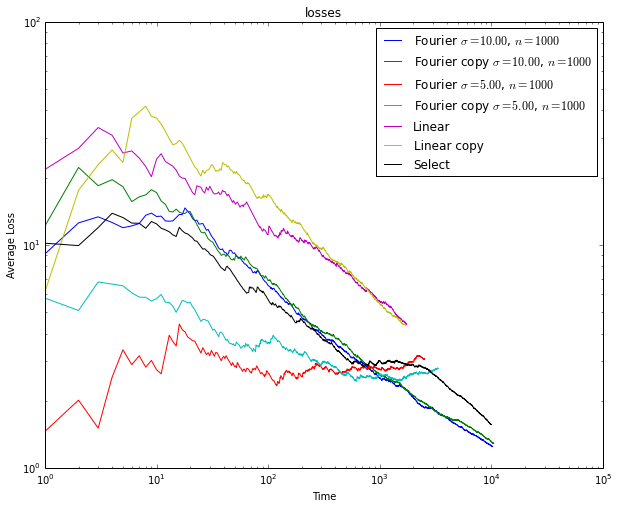

In [79]:
# <!-- hide=True -->
plotselect(banditselect,algs,overlaypred = False)

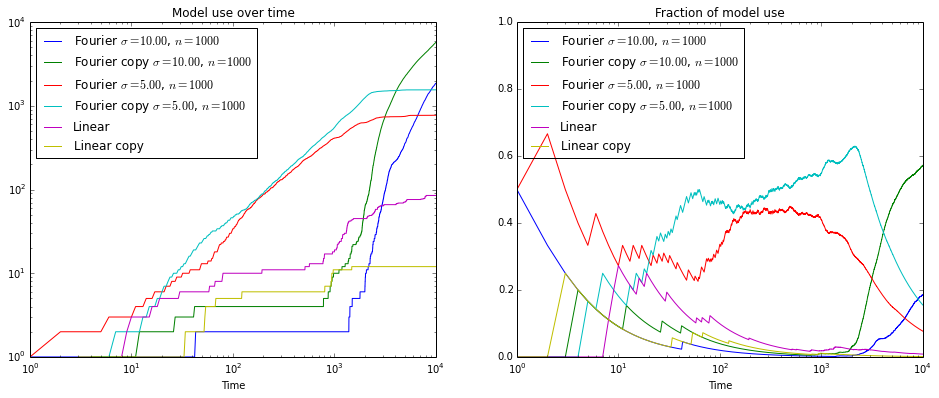

In [80]:
# <!-- hide=True -->
plotcounts(banditselect)

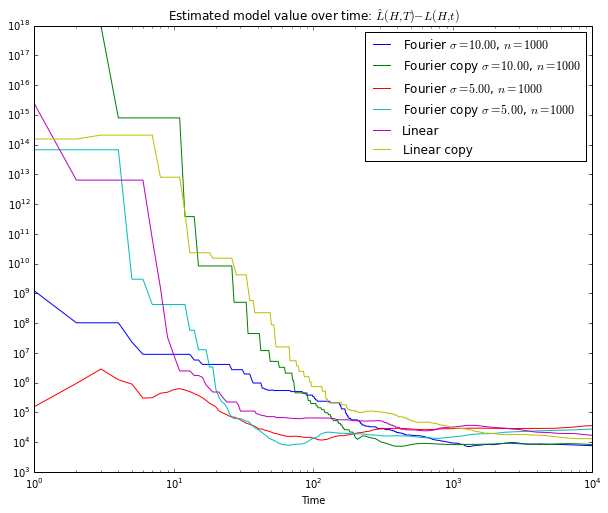

In [82]:
# <!-- hide=True -->
plotbounds(banditselect,1)

Notice that we do a little better than the previous algorithm with a much smaller burn-in time (2 vs 100). However, we are paying for this with approximately three times as much computation. Let's check out the $T$-agnostic version:

In [67]:
# <!-- hide=True -->
T = 10000
tmin = 2
guessT = True
eta = 1.0
algs = [adaF,adaFcopy,adaF2,adaF2copy,adalin,adalincopy]
banditselect = BanditAlgSelect(algs,T,tmin,eta,guessT)

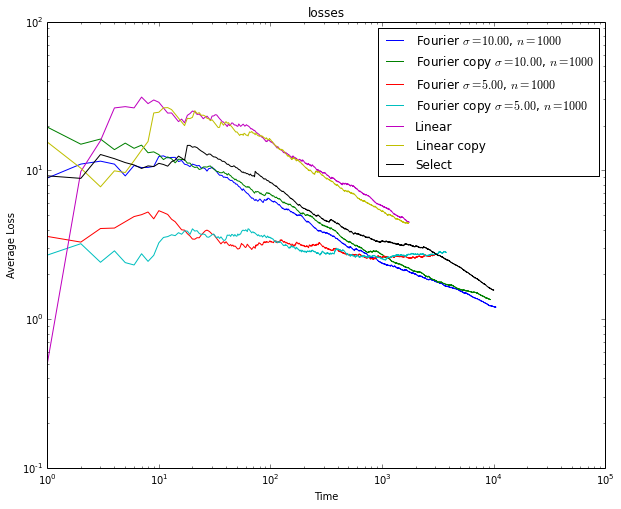

In [68]:
# <!-- hide=True -->
plotselect(banditselect,algs,overlaypred = False)

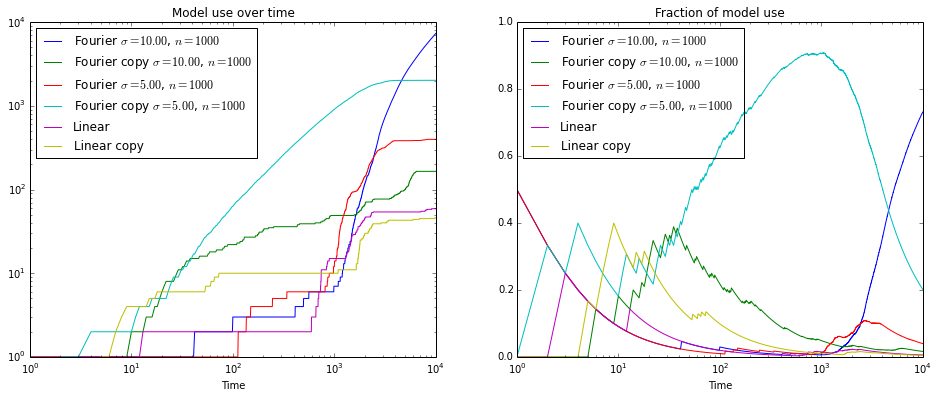

In [69]:
# <!-- hide=True -->
plotcounts(banditselect)

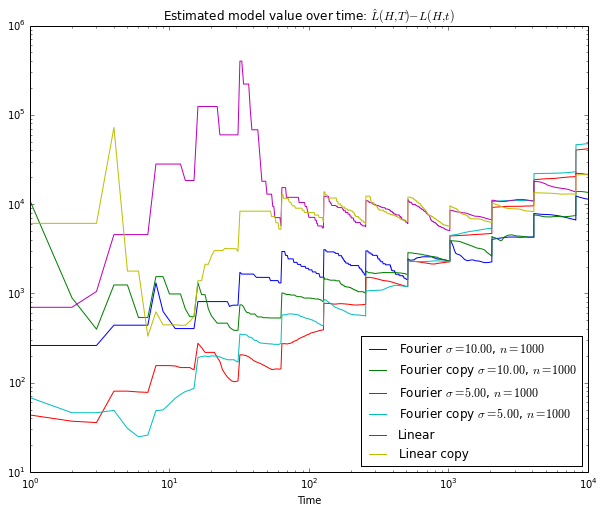

In [72]:
# <!-- hide=True -->
plotbounds(banditselect,4)

So now we're doing quite a bit better than the previous scheme did without knowing $T$, and using a much smaller burn-in time. Thus the bandit to non-bandit based scheme represents a kind of performance/computation tradeoff.